In [970]:
import pandas as pd # type:ignore
import numpy as np # type:ignore
import matplotlib.pyplot as plt # type:ignore
import seaborn as sns # type:ignore
from sklearn.datasets import make_blobs # type:ignore
from scipy.stats import multivariate_normal # type:ignore
from sklearn.metrics import confusion_matrix,classification_report # type:ignore
import warnings # type:ignore
from scipy.optimize import linear_sum_assignment # type:ignore
from matplotlib.lines import Line2D # type:ignore
from sklearn.preprocessing import StandardScaler # type:ignore
from sklearn.decomposition import PCA # type:ignore
from sklearn.manifold import TSNE # type:ignore
import umap # type:ignore
from sklearn.cluster import KMeans,DBSCAN # type:ignore
from sklearn.mixture import GaussianMixture # type:ignore
from sklearn.neighbors import NearestNeighbors # type:ignore
warnings.filterwarnings("ignore", category=UserWarning)

# data

In [971]:
np.random.seed(42)

In [972]:
def generate_correlated_clusters(n_samples,n_features,n_clusters,correlation=0.5,random_state=None):

    np.random.seed(random_state)

    X_blobs,y_blobs = make_blobs(n_samples=n_samples,centers=n_clusters,n_features=n_features,random_state=random_state)

    centers = np.array([X_blobs[y_blobs == i].mean(axis=0) for i in range(n_clusters)])

    X,y = [],[]

    for i,center in enumerate(centers):
    
        cov_matrix = np.full((n_features,n_features),correlation)  
        np.fill_diagonal(cov_matrix,1)  

        cluster_samples = np.random.multivariate_normal(mean=center,cov=cov_matrix,size=n_samples // n_clusters)

        X.append(cluster_samples)
        y.append(np.full(n_samples // n_clusters, i)) 

    X = np.vstack(X)
    y = np.hstack(y)

    return X, y

In [973]:
X, y = generate_correlated_clusters(n_samples=1000,n_features=5,n_clusters=2,correlation=0.4,random_state=42)
X = X + np.random.normal(scale=4,size=X.shape) 

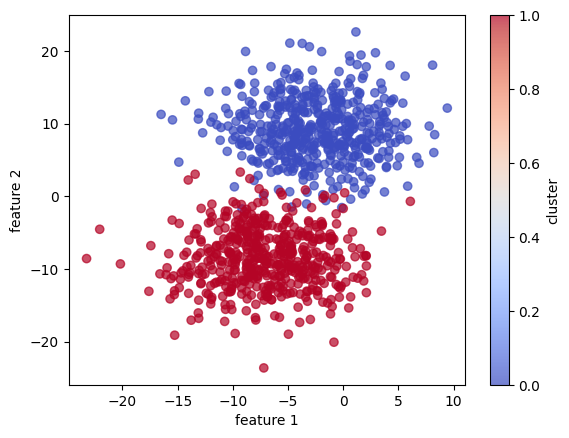

In [974]:
plt.scatter(X[:,0],X[:,1],c=y,cmap='coolwarm',alpha=0.7)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.colorbar(label="cluster")
plt.show()

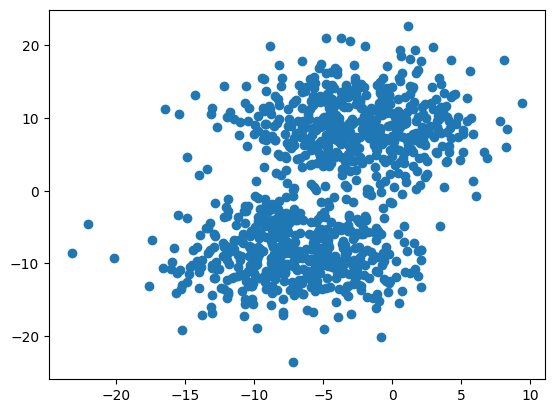

In [975]:
plt.scatter(X[:,0],X[:,1])
plt.show()

In [976]:
corr_dataset = pd.DataFrame(X) 

In [977]:
corr_dataset.columns = [f"vab_{col+1}" for col in corr_dataset.columns]

In [978]:
corr_dataset['target'] = y

In [979]:
corr_dataset

vab_1      vab_2      vab_3     vab_4      vab_5  target
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0
..        ...        ...        ...       ...        ...     ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1

[1000 rows x 6 columns]

In [980]:
# sns.pairplot(corr_dataset)

## correlation matrix

In [981]:
corr_dataset.iloc[:,:-1].corr()

vab_1     vab_2     vab_3     vab_4     vab_5
vab_1  1.000000  0.420137 -0.143520  0.023249 -0.398812
vab_2  0.420137  1.000000 -0.286631 -0.045224 -0.751095
vab_3 -0.143520 -0.286631  1.000000  0.020873  0.270438
vab_4  0.023249 -0.045224  0.020873  1.000000  0.044198
vab_5 -0.398812 -0.751095  0.270438  0.044198  1.000000

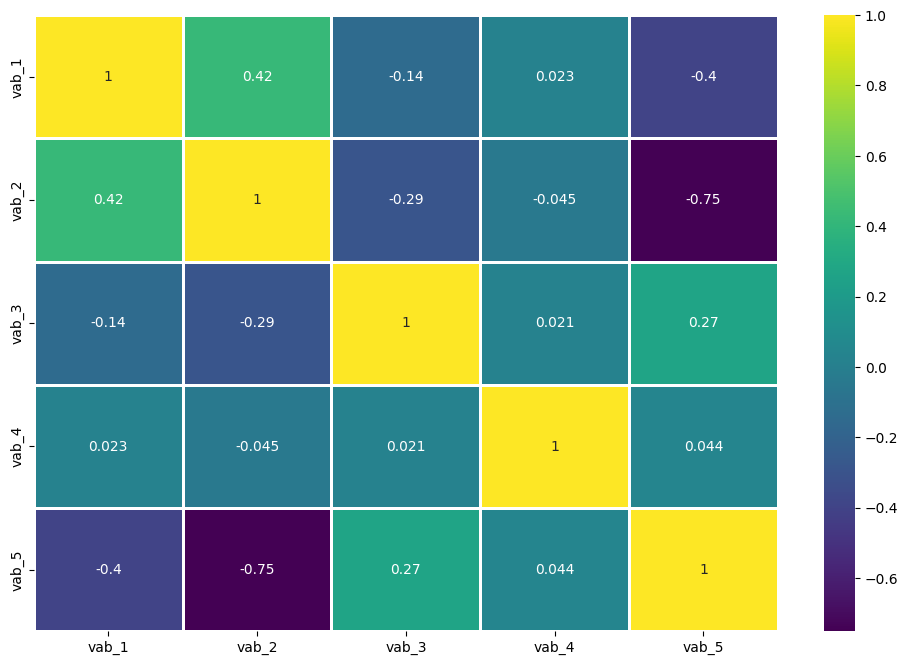

In [982]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_dataset.iloc[:,:-1].corr(),cmap='viridis',annot=True,linewidths=1)
plt.show()

## data standardization

In [983]:
X_values = corr_dataset.iloc[:,:-1].values

In [984]:
y_values = corr_dataset.iloc[:,-1].values

In [985]:
scaler = StandardScaler()

In [986]:
X_values = scaler.fit_transform(X_values)

In [987]:
np.mean(X_values),np.std(X_values)

(-3.382183422218077e-16, 0.9999999999999998)

In [988]:
pd.DataFrame(X_values)

0         1         2         3         4
0    0.027113  0.692132 -2.091882 -0.489830 -0.285544
1   -0.319493  1.380074  0.053793 -0.626391 -0.956993
2    1.786681  1.155953 -0.281046  0.356121 -0.759448
3   -0.012851  0.029240  1.610253  0.618341 -0.484043
4    0.171944  0.466031 -0.709677 -1.484734  0.282870
..        ...       ...       ...       ...       ...
995 -0.476906 -0.298135 -0.445097 -0.575497  0.026119
996 -0.494053 -1.032527  0.934995  0.461992  0.162117
997 -1.028663 -1.074143 -1.474122 -1.386525  0.064599
998  1.157033 -0.761712  1.223197 -1.059348  1.761096
999  0.747859 -1.694527 -0.841443  0.599302  1.316459

[1000 rows x 5 columns]

<Axes: ylabel='Density'>

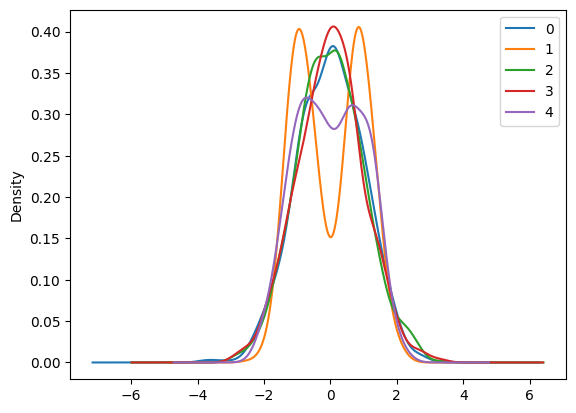

In [989]:
pd.DataFrame(X_values).plot(kind='density')

## pca 

In [990]:
pca_general = PCA()

In [991]:
pca_general.fit(X_values)

PCA()

In [992]:
explained_variance = pca_general.explained_variance_ratio_

In [993]:
explained_variance

array([0.44208135, 0.20144004, 0.17457313, 0.13225378, 0.0496517 ])

In [994]:
eigenvalues = pca_general.explained_variance_

In [995]:
pd.DataFrame(eigenvalues)

0
0  2.212619
1  1.008208
2  0.873739
3  0.661931
4  0.248507

In [996]:
eigenvectors = pca_general.components_

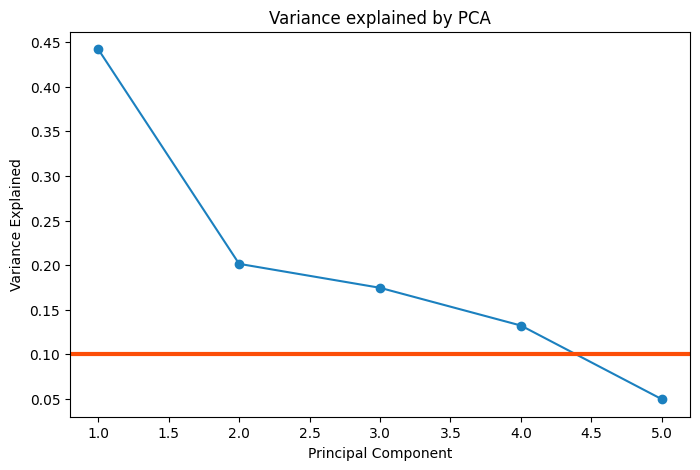

In [997]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='#1B80BF')
plt.axhline(y=0.1, color='#FC4E07', linewidth=3)
plt.title('Variance explained by PCA')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [998]:
pca = PCA(n_components=2)

In [999]:
principal_components = pca.fit_transform(X_values)

In [1000]:
pd.DataFrame(principal_components).head(8)

0         1
0  1.292140 -0.657271
1  1.252859 -0.695131
2  1.994906  0.632553
3 -0.252348  0.728569
4  0.478020 -1.481894
5  0.619623  1.227309
6  0.912684  0.652632
7  2.659728  2.333649

In [1001]:
principal_df = pd.DataFrame(data = principal_components,columns = ['principal component 1','principal component 2'])

In [1002]:
final_df = pd.concat([principal_df,corr_dataset[['target']]],axis = 1)

In [1003]:
final_df

principal component 1  principal component 2  target
0                 1.292140              -0.657271       0
1                 1.252859              -0.695131       0
2                 1.994906               0.632553       0
3                -0.252348               0.728569       0
4                 0.478020              -1.481894       0
..                     ...                    ...     ...
995              -0.233680              -0.684358       1
996              -1.249677               0.451288       1
997              -0.592567              -1.655691       1
998              -1.336595              -0.693146       1
999              -1.206630               0.691001       1

[1000 rows x 3 columns]

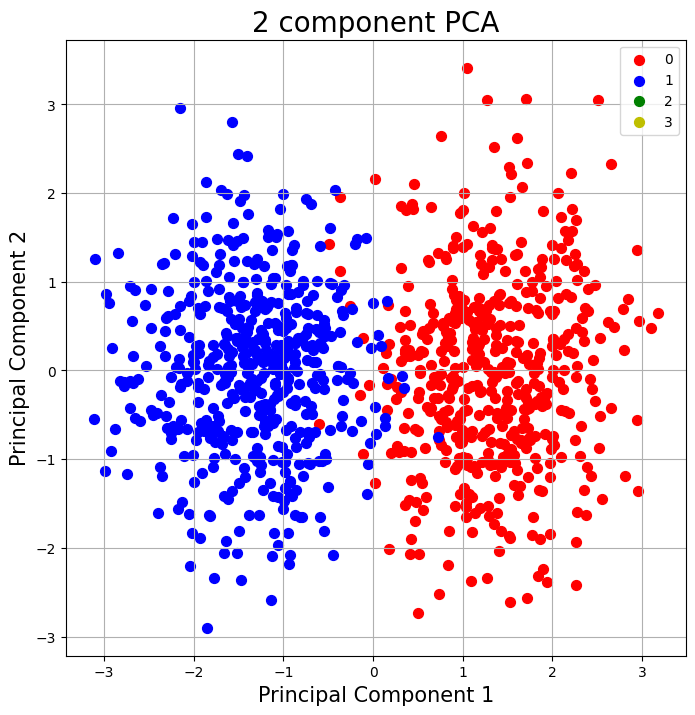

In [1004]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1',fontsize = 15)
ax.set_ylabel('Principal Component 2',fontsize = 15)
ax.set_title('2 component PCA',fontsize = 20)

targets = [0,1,2,3]
colors = ['r','b','g','y']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['target'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               ,final_df.loc[indicesToKeep, 'principal component 2']
               ,c = color
               ,s = 50)
ax.legend(targets)
ax.grid()

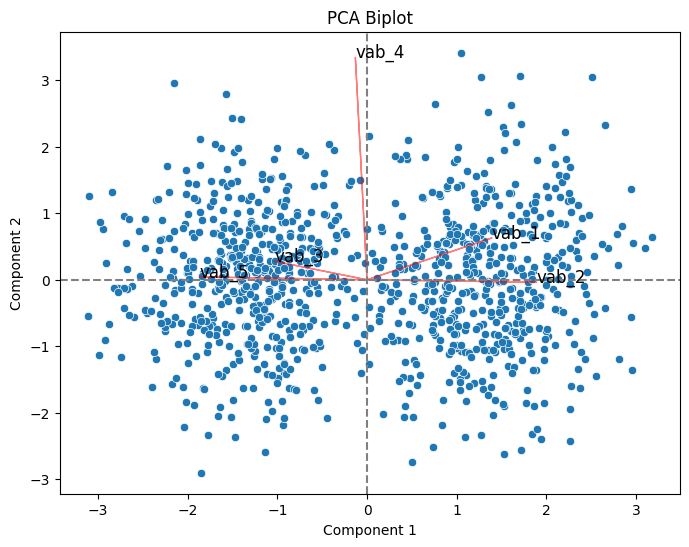

In [1005]:
scores = pca.transform(X_values)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1])
for i, col in enumerate(corr_dataset.iloc[:,:-1].columns):
    plt.arrow(0, 0, eigenvectors[0, i] * max(scores[:, 0]), eigenvectors[1, i] * max(scores[:, 1]), color='r', alpha=0.5)
    plt.text(eigenvectors[0, i] * max(scores[:, 0]), eigenvectors[1, i] * max(scores[:, 1]), col, fontsize=12)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Biplot')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.show()

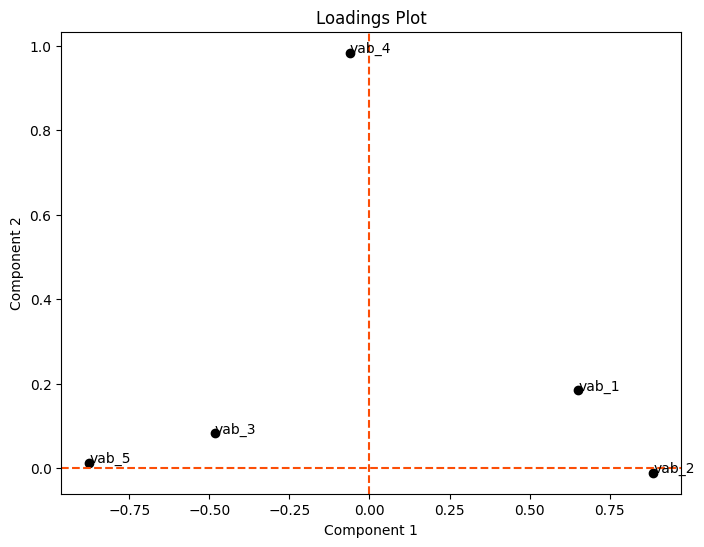

In [1006]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 0], loadings[:, 1], color='black')
for i, txt in enumerate(corr_dataset.iloc[:,:-1].columns):
    plt.text(loadings[i, 0], loadings[i, 1], txt, fontsize=10)
plt.axhline(0, color='#FC4E07', linestyle='--')
plt.axvline(0, color='#FC4E07', linestyle='--')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Loadings Plot')
plt.show()

In [1007]:
scores_pca = pca.transform(X_values)

In [1008]:
pd.DataFrame(scores_pca).head()

0         1
0  1.292140 -0.657271
1  1.252859 -0.695131
2  1.994906  0.632553
3 -0.252348  0.728569
4  0.478020 -1.481894

## t-SNE

In [1009]:
tsne = TSNE(n_components=2,random_state=42)

In [1010]:
X_tsne = tsne.fit_transform(X_values)

In [1011]:
tsne_data = pd.concat([pd.DataFrame(X_tsne,columns=('dim_1','dim_2')),corr_dataset['target']],axis=1)

In [1012]:
tsne_data

dim_1      dim_2  target
0    30.976816   1.005864       0
1    23.977455   7.949975       0
2    46.130104  -5.348682       0
3     9.549825  -8.663972       0
4    32.127357  18.956821       0
..         ...        ...     ...
995 -21.674974 -16.751673       1
996 -25.219442   4.039253       1
997 -21.045013 -19.986071       1
998 -18.831089  -9.052222       1
999 -12.437759  14.460580       1

[1000 rows x 3 columns]

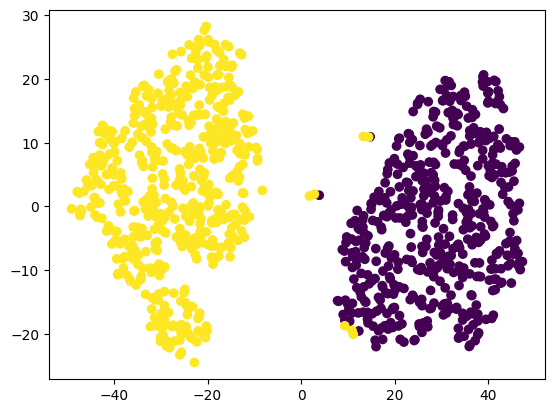

In [1013]:
plt.scatter(x=tsne_data['dim_1'],y=tsne_data['dim_2'],c=tsne_data['target'])
plt.show()

In [1014]:
tsne.kl_divergence_

1.070916771888733

## umap

In [1015]:
umap = umap.UMAP(random_state=42)

In [1016]:
X_umap = umap.fit_transform(X_values)

In [1017]:
umap_data = pd.concat([pd.DataFrame(X_umap,columns=('dim_1','dim_2')),corr_dataset['target']],axis=1)

In [1018]:
umap_data

dim_1     dim_2  target
0    -3.553547  6.372024       0
1    -2.102529  5.924346       0
2    -3.003285  9.191651       0
3    -0.360630  6.983538       0
4    -2.614740  4.931720       0
..         ...       ...     ...
995  10.370522  3.903336       1
996   9.158760  6.764127       1
997  10.839982  4.066079       1
998   8.266351  5.204938       1
999  10.156680  6.242321       1

[1000 rows x 3 columns]

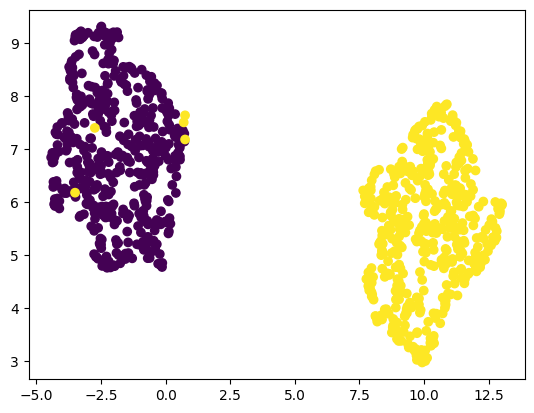

In [1019]:
plt.scatter(umap_data['dim_1'],umap_data['dim_2'],c=umap_data['target'])
plt.show()

## k-means 

In [1020]:
kmeans = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [1021]:
kmeans.fit(X_values)

KMeans(n_clusters=2, random_state=42)

In [1022]:
df_kmeans = corr_dataset.copy()

In [1023]:
df_kmeans['k_means'] = kmeans.labels_

In [1024]:
df_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  k_means
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0        0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0        0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0        0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0        1
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0        0
..        ...        ...        ...       ...        ...     ...      ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1        1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1        1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1        1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1        1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1        1

[1000 rows x 7 columns]

In [1025]:
y_true = df_kmeans['target'].values  
y_kmeans = df_kmeans['k_means'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_kmeans['k_means'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_kmeans['k_means'] == y_true))

accuracy before: 0.988
accuracy after: 0.988


In [1026]:
df_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  k_means
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0        0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0        0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0        0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0        1
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0        0
..        ...        ...        ...       ...        ...     ...      ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1        1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1        1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1        1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1        1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1        1

[1000 rows x 7 columns]

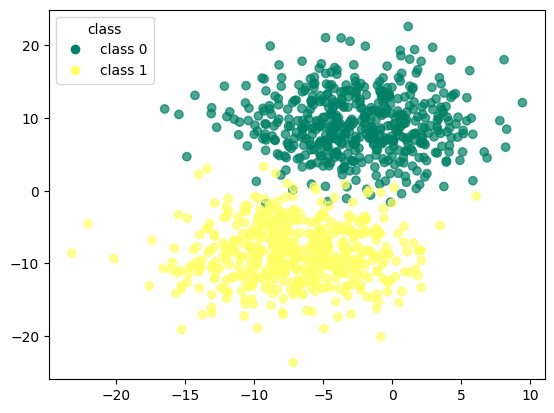

In [1027]:
scatter = plt.scatter(df_kmeans.iloc[:, 0], df_kmeans.iloc[:, 1], 
                      c=df_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

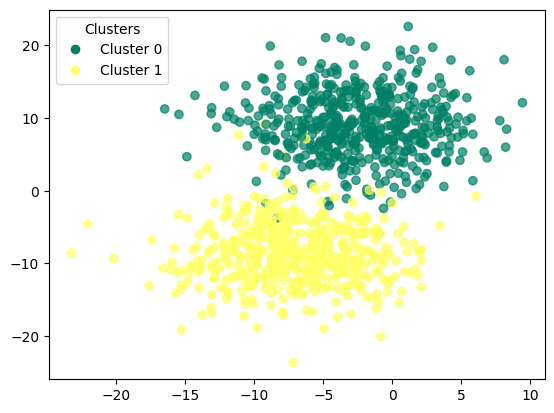

In [1028]:
scatter = plt.scatter(df_kmeans.iloc[:, 0], df_kmeans.iloc[:, 1], 
                      c=df_kmeans['k_means'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_kmeans['k_means'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [1029]:
kmeans.cluster_centers_

array([[ 0.47530804,  0.89162642, -0.33372177, -0.06296254, -0.81903169],
       [-0.47912577, -0.89878808,  0.33640227,  0.06346827,  0.82561026]])

In [1030]:
print(confusion_matrix(df_kmeans['target'],df_kmeans['k_means']))

[[495   5]
 [  7 493]]


In [1031]:
print(classification_report(df_kmeans['target'],df_kmeans['k_means']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       0.99      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



### k-means with pca

In [1032]:
kmeans_pca = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [1033]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=2, random_state=42)

In [1034]:
df_pca_kmeans = corr_dataset.copy()

In [1035]:
df_pca_kmeans["kmeans_pca"] = kmeans_pca.labels_

In [1036]:
df_pca_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  kmeans_pca
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0           0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0           0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0           0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0           1
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0           0
..        ...        ...        ...       ...        ...     ...         ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1           1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1           1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1           1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1           1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1           1

[1000 rows x 7 columns]

In [1037]:
y_true = df_pca_kmeans['target'].values  
y_kmeans = df_pca_kmeans['kmeans_pca'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_pca_kmeans['kmeans_pca'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_pca_kmeans['kmeans_pca'] == y_true))

accuracy before: 0.979
accuracy after: 0.979


In [1038]:
df_pca_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  kmeans_pca
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0           0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0           0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0           0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0           1
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0           0
..        ...        ...        ...       ...        ...     ...         ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1           1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1           1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1           1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1           1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1           1

[1000 rows x 7 columns]

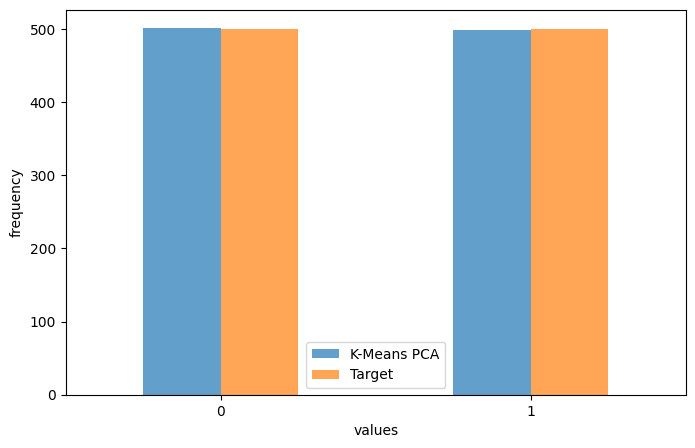

In [1039]:
counts_kmeans = df_pca_kmeans['kmeans_pca'].value_counts().sort_index()
counts_target = df_pca_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means PCA': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means PCA", "Target"])
plt.xticks(rotation=0)  
plt.show()


In [1040]:
print(confusion_matrix(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

[[490  10]
 [ 11 489]]


In [1041]:
print(classification_report(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       500
           1       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



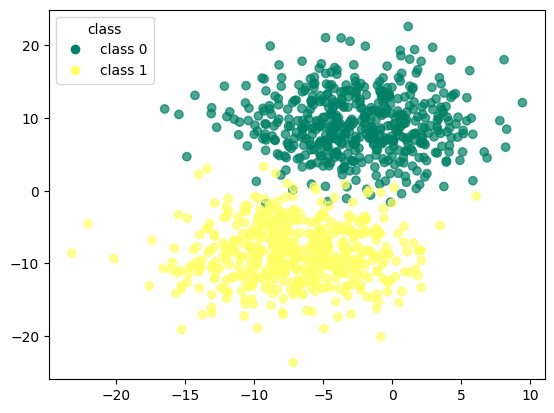

In [1042]:
scatter = plt.scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                      c=df_pca_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

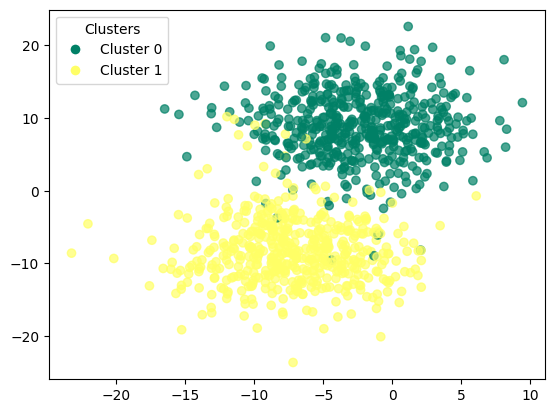

In [1043]:
scatter = plt.scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                      c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

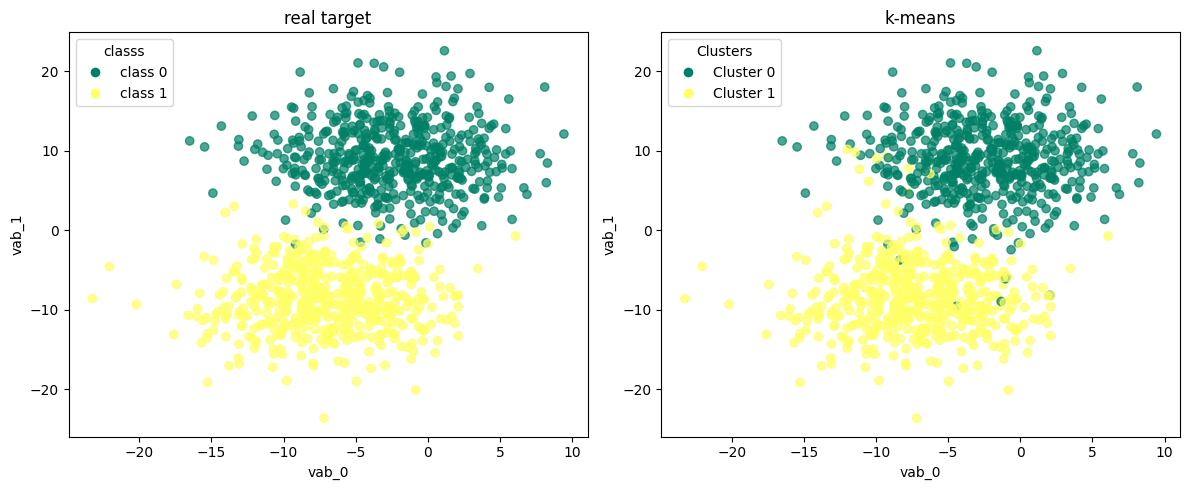

In [1044]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                           c=df_pca_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 1], 
                           c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

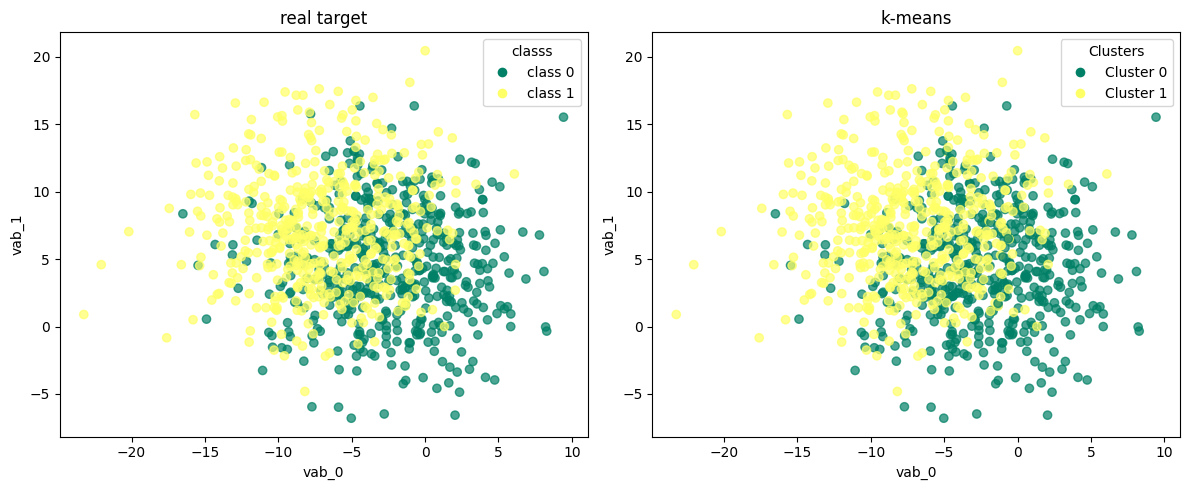

In [1045]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 2], 
                           c=df_pca_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_kmeans.iloc[:, 0], df_pca_kmeans.iloc[:, 2], 
                           c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_kmeans['kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

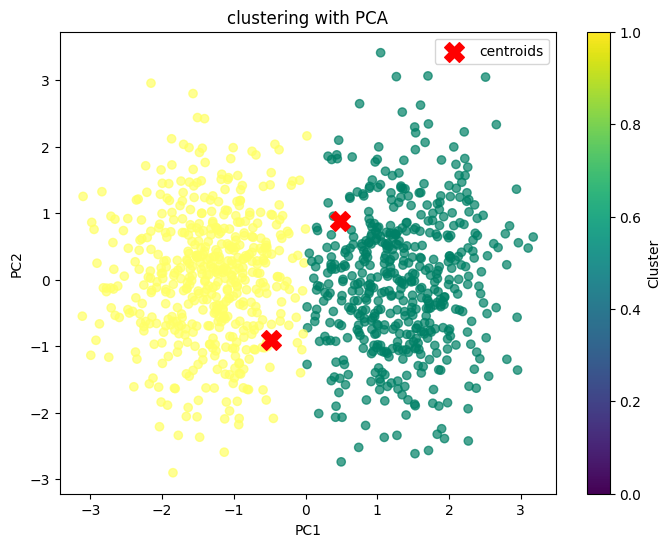

In [1046]:
plt.figure(figsize=(8, 6))
plt.scatter(final_df['principal component 1'], final_df['principal component 2'] , c=df_pca_kmeans['kmeans_pca'], cmap='summer', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', marker='X', s=200, label='centroids')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('clustering with PCA')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

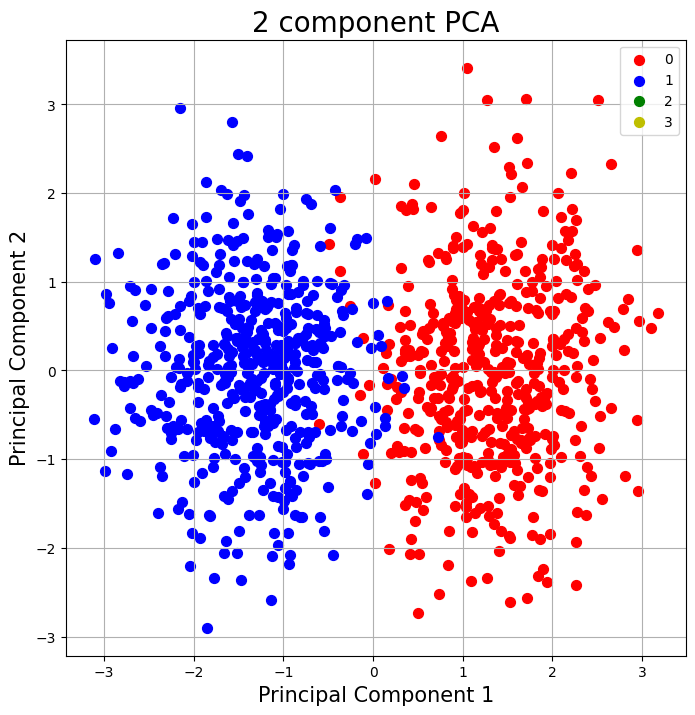

In [1047]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1',fontsize = 15)
ax.set_ylabel('Principal Component 2',fontsize = 15)
ax.set_title('2 component PCA',fontsize = 20)

targets = [0,1,2,3]
colors = ['r','b','g','y']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['target'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               ,final_df.loc[indicesToKeep, 'principal component 2']
               ,c = color
               ,s = 50)
ax.legend(targets)
ax.grid()

### k-means with t-SNE

In [1048]:
kmeans_tsne = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [1049]:
kmeans_tsne.fit(X_tsne)

KMeans(n_clusters=2, random_state=42)

In [1050]:
df_tsne_kmeans = corr_dataset.copy()

In [1051]:
df_tsne_kmeans['kmeans_tsne'] = kmeans_tsne.labels_

In [1052]:
df_tsne_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  kmeans_tsne
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0            0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0            0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0            0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0            0
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0            0
..        ...        ...        ...       ...        ...     ...          ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1            1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1            1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1            1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1            1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1            1

[1000 rows x 7 columns]

In [1053]:
y_true = df_tsne_kmeans['target'].values  
y_kmeans = df_tsne_kmeans['kmeans_tsne'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_tsne_kmeans['kmeans_tsne'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_tsne_kmeans['kmeans_tsne'] == y_true))

accuracy before: 0.993
accuracy after: 0.993


In [1054]:
df_tsne_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  kmeans_tsne
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0            0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0            0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0            0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0            0
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0            0
..        ...        ...        ...       ...        ...     ...          ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1            1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1            1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1            1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1            1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1            1

[1000 rows x 7 columns]

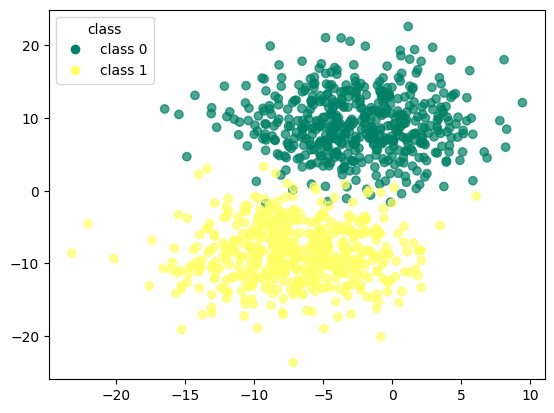

In [1055]:
scatter = plt.scatter(df_tsne_kmeans.iloc[:, 0], df_tsne_kmeans.iloc[:, 1], 
                      c=df_tsne_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

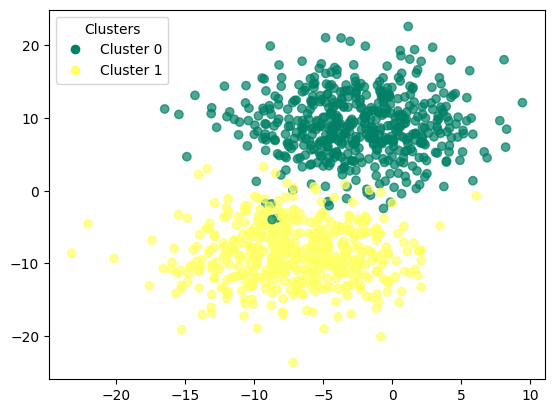

In [1056]:
scatter = plt.scatter(df_tsne_kmeans.iloc[:, 0], df_tsne_kmeans.iloc[:, 1], 
                      c=df_tsne_kmeans['kmeans_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_kmeans['kmeans_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

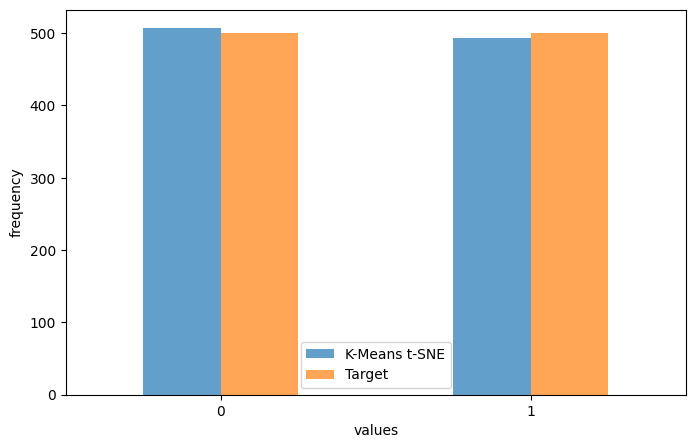

In [1057]:
counts_kmeans = df_tsne_kmeans['kmeans_tsne'].value_counts().sort_index()
counts_target = df_tsne_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means t-SNE': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means t-SNE", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [1058]:
print(confusion_matrix(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne']))

[[500   0]
 [  7 493]]


In [1059]:
print(classification_report(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



### k-means with umap

In [1060]:
kmeans_umap = KMeans(n_clusters=2,init='k-means++',random_state=42)

In [1061]:
kmeans_umap.fit(X_umap)

KMeans(n_clusters=2, random_state=42)

In [1062]:
df_umap_kmeans = corr_dataset.copy()

In [1063]:
df_umap_kmeans['kmeans_umap'] = kmeans_umap.labels_

In [1064]:
df_umap_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  kmeans_umap
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0            0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0            0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0            0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0            0
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0            0
..        ...        ...        ...       ...        ...     ...          ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1            1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1            1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1            1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1            1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1            1

[1000 rows x 7 columns]

In [1065]:
y_true = df_umap_kmeans['target'].values  
y_kmeans = df_umap_kmeans['kmeans_umap'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_umap_kmeans['kmeans_umap'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_umap_kmeans['kmeans_umap'] == y_true))

accuracy before: 0.995
accuracy after: 0.995


In [1066]:
df_umap_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  kmeans_umap
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0            0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0            0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0            0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0            0
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0            0
..        ...        ...        ...       ...        ...     ...          ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1            1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1            1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1            1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1            1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1            1

[1000 rows x 7 columns]

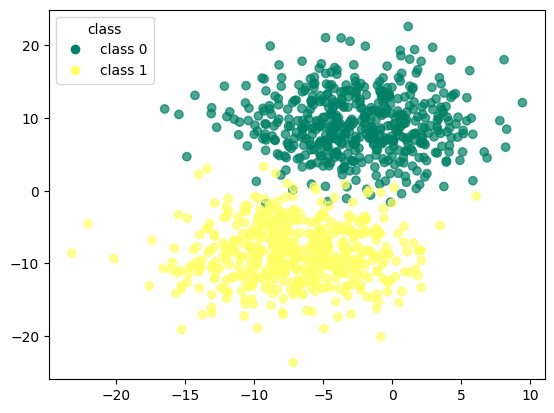

In [1067]:
scatter = plt.scatter(df_umap_kmeans.iloc[:, 0], df_umap_kmeans.iloc[:, 1], 
                      c=df_umap_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_umap_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

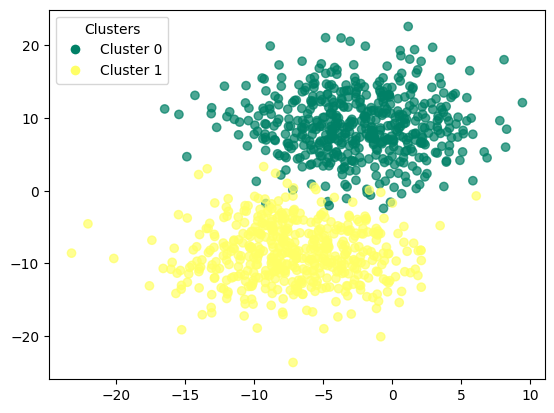

In [1068]:
scatter = plt.scatter(df_umap_kmeans.iloc[:, 0], df_umap_kmeans.iloc[:, 1], 
                      c=df_umap_kmeans['kmeans_umap'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_umap_kmeans['kmeans_umap'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

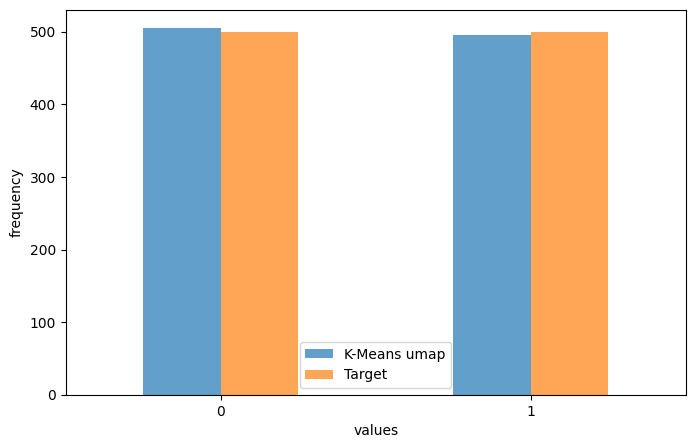

In [1069]:
counts_kmeans = df_umap_kmeans['kmeans_umap'].value_counts().sort_index()
counts_target = df_umap_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means umap': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means umap", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [1070]:
print(confusion_matrix(df_umap_kmeans['target'],df_umap_kmeans['kmeans_umap']))

[[500   0]
 [  5 495]]


In [1071]:
print(classification_report(df_umap_kmeans['target'],df_umap_kmeans['kmeans_umap'])) 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



## trimmed k-means

In [1072]:
def trimmed_clustering(X,n_clusters,trim_fraction=0.1):

    kmeans = KMeans(n_clusters=n_clusters,random_state=42).fit(X)
    distances = np.min(kmeans.transform(X),axis=1)
    
    trim_threshold = np.percentile(distances,100 * (1 - trim_fraction))
    trimmed_X = X[distances < trim_threshold]
    trimmed_indices = np.where(distances < trim_threshold)[0]
    trimmed_kmeans = KMeans(n_clusters=n_clusters,random_state=42).fit(trimmed_X)
    
    return trimmed_kmeans,trimmed_indices

In [1073]:
trimmed_kmeans,trimmmed_indces = trimmed_clustering(X_values,n_clusters=2,trim_fraction=0.1)

In [1074]:
trimmed_kmeans

KMeans(n_clusters=2, random_state=42)

In [1075]:
df_trim_kmeans = corr_dataset.copy()

In [1076]:
df_trim_kmeans = df_trim_kmeans.iloc[trimmmed_indces]  

In [1077]:
df_trim_kmeans['trim_kmeans'] = trimmed_kmeans.labels_

In [1078]:
df_trim_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  trim_kmeans
0    -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0            0
1    -6.335035  13.785559   6.136146 -0.910381  -7.882775       0            0
2     3.903740  11.599888   4.664921  3.146283  -6.521366       0            0
3    -4.844349   0.611977  12.974970  4.228953  -4.623374       0            1
4    -3.946004   4.871646   2.781589 -4.454364   0.661903       0            0
..         ...        ...        ...       ...        ...     ...          ...
994 -11.687795  -8.337973   9.950949  4.862808   8.378993       1            1
995  -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1            1
996  -7.183624  -9.742562  10.008001  3.583407  -0.170281       1            1
998   0.842822  -7.101524  11.274309 -2.698003  10.849289       1            1
999  -1.146299 -16.198506   2.202632  4.150342   7.785018       1            1

[900 rows x 7 columns]

In [1079]:
y_true = df_trim_kmeans['target'].values  
y_kmeans = df_trim_kmeans['trim_kmeans'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_trim_kmeans['trim_kmeans'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_trim_kmeans['trim_kmeans'] == y_true))

accuracy before: 0.99
accuracy after: 0.99


In [1080]:
df_trim_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  trim_kmeans
0    -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0            0
1    -6.335035  13.785559   6.136146 -0.910381  -7.882775       0            0
2     3.903740  11.599888   4.664921  3.146283  -6.521366       0            0
3    -4.844349   0.611977  12.974970  4.228953  -4.623374       0            1
4    -3.946004   4.871646   2.781589 -4.454364   0.661903       0            0
..         ...        ...        ...       ...        ...     ...          ...
994 -11.687795  -8.337973   9.950949  4.862808   8.378993       1            1
995  -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1            1
996  -7.183624  -9.742562  10.008001  3.583407  -0.170281       1            1
998   0.842822  -7.101524  11.274309 -2.698003  10.849289       1            1
999  -1.146299 -16.198506   2.202632  4.150342   7.785018       1            1

[900 rows x 7 columns]

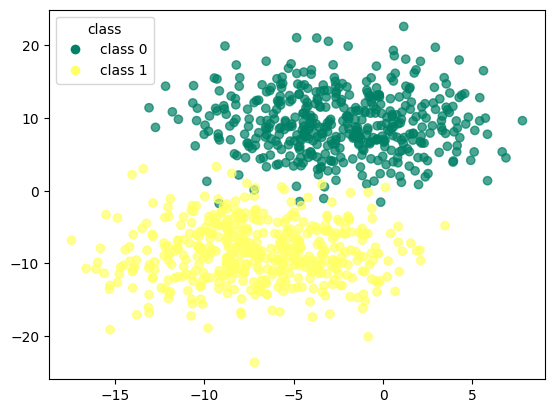

In [1081]:
scatter = plt.scatter(df_trim_kmeans.iloc[:, 0], df_trim_kmeans.iloc[:, 1], 
                      c=df_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_trim_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

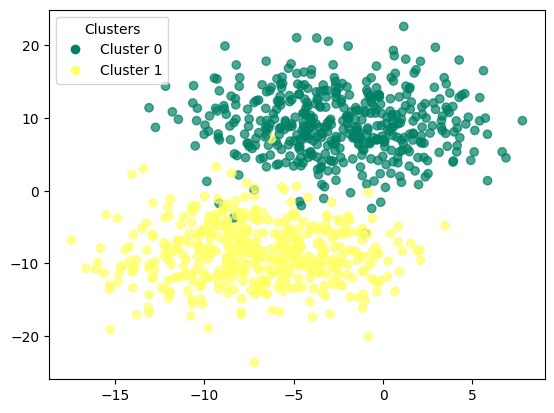

In [1082]:
scatter = plt.scatter(df_trim_kmeans.iloc[:, 0], df_trim_kmeans.iloc[:, 1], 
                      c=df_trim_kmeans['trim_kmeans'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_trim_kmeans['trim_kmeans'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [1083]:
print(confusion_matrix(df_trim_kmeans['target'],df_trim_kmeans['trim_kmeans']))

[[440   2]
 [  7 451]]


In [1084]:
print(classification_report(df_trim_kmeans['target'],df_trim_kmeans['trim_kmeans']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       442
           1       1.00      0.98      0.99       458

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



### trimmed k-means with pca

In [1085]:
trim_kmeans_pca,trimmmed_indices = trimmed_clustering(scores_pca,n_clusters=2,trim_fraction=0.1)

In [1086]:
trim_kmeans_pca

KMeans(n_clusters=2, random_state=42)

In [1087]:
df_pca_trim_kmeans = corr_dataset.copy()

In [1088]:
df_pca_trim_kmeans = df_pca_trim_kmeans.iloc[trimmmed_indces]  

In [1089]:
df_pca_trim_kmeans["trim_kmeans_pca"] = trim_kmeans_pca.labels_

In [1090]:
df_pca_trim_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  \
0    -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0   
1    -6.335035  13.785559   6.136146 -0.910381  -7.882775       0   
2     3.903740  11.599888   4.664921  3.146283  -6.521366       0   
3    -4.844349   0.611977  12.974970  4.228953  -4.623374       0   
4    -3.946004   4.871646   2.781589 -4.454364   0.661903       0   
..         ...        ...        ...       ...        ...     ...   
994 -11.687795  -8.337973   9.950949  4.862808   8.378993       1   
995  -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1   
996  -7.183624  -9.742562  10.008001  3.583407  -0.170281       1   
998   0.842822  -7.101524  11.274309 -2.698003  10.849289       1   
999  -1.146299 -16.198506   2.202632  4.150342   7.785018       1   

     trim_kmeans_pca  
0                  0  
1                  0  
2                  0  
3                  1  
4                  0  
..               ...  
994                1  
995                1  
996                1  
998                1  
999                1  

[900 rows x 7 columns]

In [1091]:
y_true = df_pca_trim_kmeans['target'].values  
y_kmeans = df_pca_trim_kmeans['trim_kmeans_pca'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_pca_trim_kmeans['trim_kmeans_pca'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_pca_trim_kmeans['trim_kmeans_pca'] == y_true))

accuracy before: 0.9766666666666667
accuracy after: 0.9766666666666667


In [1092]:
df_pca_trim_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  \
0    -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0   
1    -6.335035  13.785559   6.136146 -0.910381  -7.882775       0   
2     3.903740  11.599888   4.664921  3.146283  -6.521366       0   
3    -4.844349   0.611977  12.974970  4.228953  -4.623374       0   
4    -3.946004   4.871646   2.781589 -4.454364   0.661903       0   
..         ...        ...        ...       ...        ...     ...   
994 -11.687795  -8.337973   9.950949  4.862808   8.378993       1   
995  -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1   
996  -7.183624  -9.742562  10.008001  3.583407  -0.170281       1   
998   0.842822  -7.101524  11.274309 -2.698003  10.849289       1   
999  -1.146299 -16.198506   2.202632  4.150342   7.785018       1   

     trim_kmeans_pca  
0                  0  
1                  0  
2                  0  
3                  1  
4                  0  
..               ...  
994                1  
995                1  
996                1  
998                1  
999                1  

[900 rows x 7 columns]

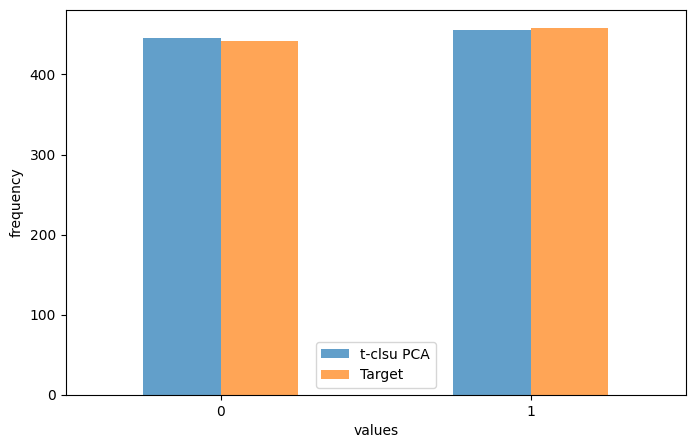

In [1093]:
counts_kmeans = df_pca_trim_kmeans['trim_kmeans_pca'].value_counts().sort_index()
counts_target = df_pca_trim_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'t-clust PCA': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["t-clsu PCA", "Target"])
plt.xticks(rotation=0)  
plt.show()


In [1094]:
print(confusion_matrix(df_pca_trim_kmeans['target'],df_pca_trim_kmeans['trim_kmeans_pca']))

[[433   9]
 [ 12 446]]


In [1095]:
print(classification_report(df_pca_trim_kmeans['target'],df_pca_trim_kmeans['trim_kmeans_pca']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       442
           1       0.98      0.97      0.98       458

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



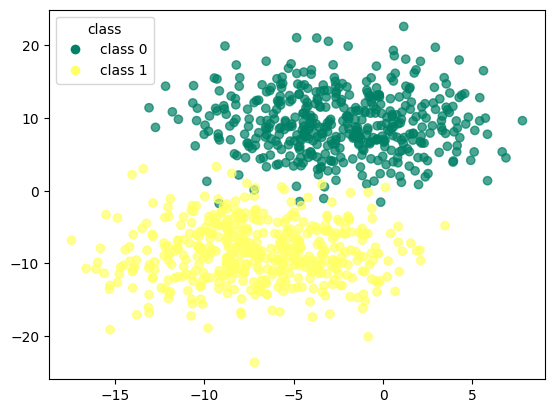

In [1096]:
scatter = plt.scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 1], 
                      c=df_pca_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_trim_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

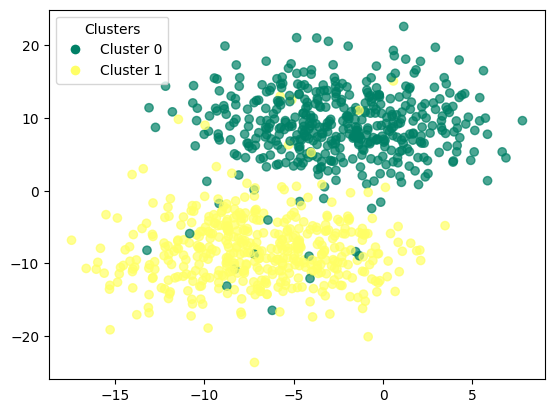

In [1097]:
scatter = plt.scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 1], 
                      c=df_pca_trim_kmeans['trim_kmeans_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_trim_kmeans['trim_kmeans_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

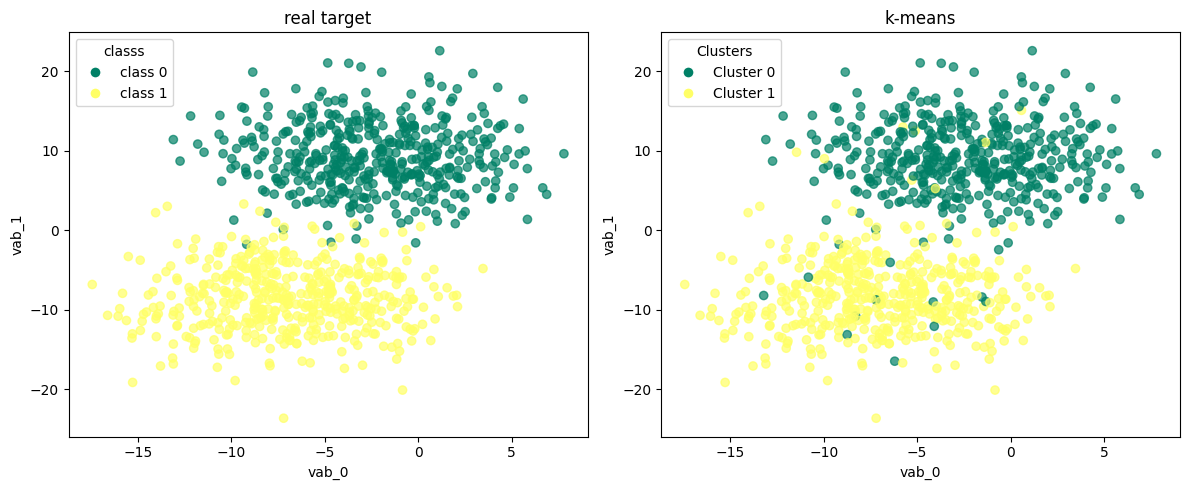

In [1098]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 1], 
                           c=df_pca_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_trim_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 1], 
                           c=df_pca_trim_kmeans['trim_kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_trim_kmeans['trim_kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

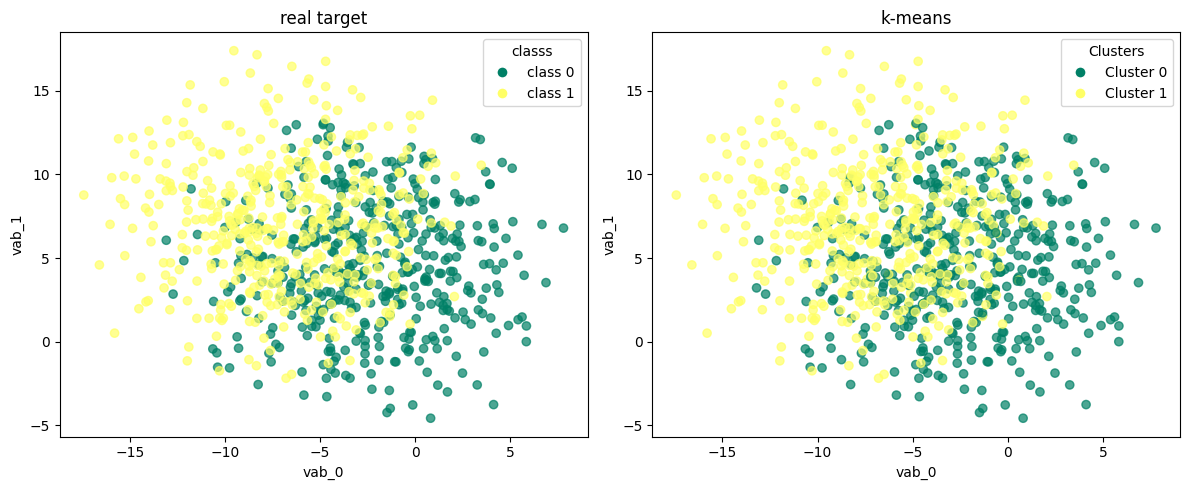

In [1099]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

scatter1 = axes[0].scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 2], 
                           c=df_pca_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_trim_kmeans['target'])
legend_elements1 = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                           markerfacecolor=scatter1.cmap(scatter1.norm(label)), markersize=8) 
                    for label in unique_labels]
axes[0].legend(handles=legend_elements1, title="classs")
axes[0].set_title("real target")

scatter2 = axes[1].scatter(df_pca_trim_kmeans.iloc[:, 0], df_pca_trim_kmeans.iloc[:, 2], 
                           c=df_pca_trim_kmeans['trim_kmeans_pca'], cmap='summer', alpha=0.7)

unique_clusters = np.unique(df_pca_trim_kmeans['trim_kmeans_pca'])
legend_elements2 = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                           markerfacecolor=scatter2.cmap(scatter2.norm(cluster)), markersize=8) 
                    for cluster in unique_clusters]
axes[1].legend(handles=legend_elements2, title="Clusters")
axes[1].set_title("k-means")

for ax in axes:
    ax.set_xlabel("vab_0")
    ax.set_ylabel("vab_1")

plt.tight_layout()  
plt.show()

### trimmed k-means with t-SNE

In [1100]:
trim_kmeans_tsne,trimmmed_indices = trimmed_clustering(X_tsne,n_clusters=2,trim_fraction=0.1)

In [1101]:
trim_kmeans_tsne

KMeans(n_clusters=2, random_state=42)

In [1102]:
df_tsne_trim_kmeans = corr_dataset.copy()

In [1103]:
df_tsne_trim_kmeans = df_tsne_trim_kmeans.iloc[trimmmed_indces]  

In [1104]:
df_tsne_trim_kmeans['trim_kmeans_tsne'] = trim_kmeans_tsne.labels_

In [1105]:
df_tsne_trim_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  \
0    -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0   
1    -6.335035  13.785559   6.136146 -0.910381  -7.882775       0   
2     3.903740  11.599888   4.664921  3.146283  -6.521366       0   
3    -4.844349   0.611977  12.974970  4.228953  -4.623374       0   
4    -3.946004   4.871646   2.781589 -4.454364   0.661903       0   
..         ...        ...        ...       ...        ...     ...   
994 -11.687795  -8.337973   9.950949  4.862808   8.378993       1   
995  -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1   
996  -7.183624  -9.742562  10.008001  3.583407  -0.170281       1   
998   0.842822  -7.101524  11.274309 -2.698003  10.849289       1   
999  -1.146299 -16.198506   2.202632  4.150342   7.785018       1   

     trim_kmeans_tsne  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
994                 1  
995                 1  
996                 1  
998                 1  
999                 1  

[900 rows x 7 columns]

In [1106]:
y_true = df_tsne_trim_kmeans['target'].values  
y_kmeans = df_tsne_trim_kmeans['trim_kmeans_tsne'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_tsne_trim_kmeans['trim_kmeans_tsne'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_tsne_trim_kmeans['trim_kmeans_tsne'] == y_true))

accuracy before: 0.9777777777777777
accuracy after: 0.9777777777777777


In [1107]:
df_tsne_trim_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  \
0    -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0   
1    -6.335035  13.785559   6.136146 -0.910381  -7.882775       0   
2     3.903740  11.599888   4.664921  3.146283  -6.521366       0   
3    -4.844349   0.611977  12.974970  4.228953  -4.623374       0   
4    -3.946004   4.871646   2.781589 -4.454364   0.661903       0   
..         ...        ...        ...       ...        ...     ...   
994 -11.687795  -8.337973   9.950949  4.862808   8.378993       1   
995  -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1   
996  -7.183624  -9.742562  10.008001  3.583407  -0.170281       1   
998   0.842822  -7.101524  11.274309 -2.698003  10.849289       1   
999  -1.146299 -16.198506   2.202632  4.150342   7.785018       1   

     trim_kmeans_tsne  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
994                 1  
995                 1  
996                 1  
998                 1  
999                 1  

[900 rows x 7 columns]

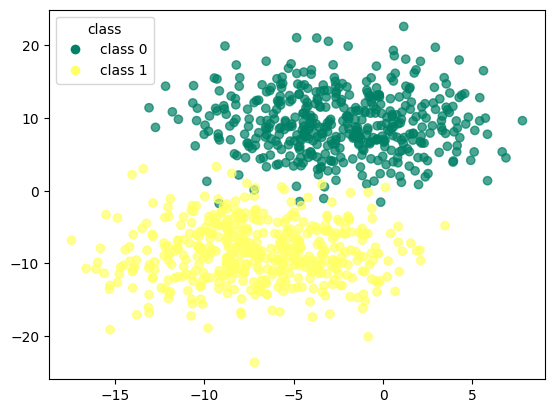

In [1108]:
scatter = plt.scatter(df_tsne_trim_kmeans.iloc[:, 0], df_tsne_trim_kmeans.iloc[:, 1], 
                      c=df_tsne_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_trim_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

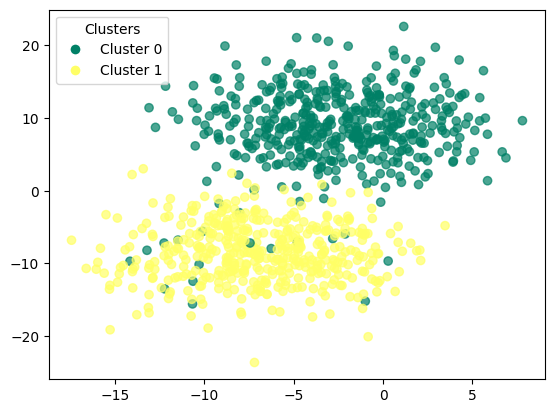

In [1109]:
scatter = plt.scatter(df_tsne_trim_kmeans.iloc[:, 0], df_tsne_trim_kmeans.iloc[:, 1], 
                      c=df_tsne_trim_kmeans['trim_kmeans_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_trim_kmeans['trim_kmeans_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

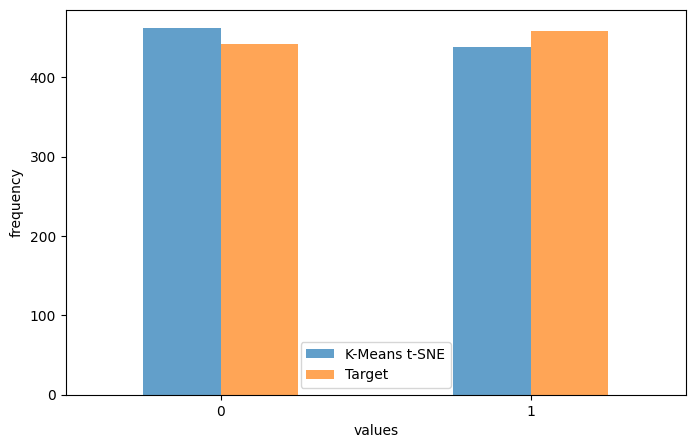

In [1110]:
counts_kmeans = df_tsne_trim_kmeans['trim_kmeans_tsne'].value_counts().sort_index()
counts_target = df_tsne_trim_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means t-SNE': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means t-SNE", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [1111]:
print(confusion_matrix(df_tsne_trim_kmeans['target'],df_tsne_trim_kmeans['trim_kmeans_tsne']))

[[442   0]
 [ 20 438]]


In [1112]:
print(classification_report(df_tsne_trim_kmeans['target'],df_tsne_trim_kmeans['trim_kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       442
           1       1.00      0.96      0.98       458

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



### trimmed k-means with umap

In [1113]:
trim_kmeans_umap,trimmmed_indices = trimmed_clustering(X_umap,n_clusters=2,trim_fraction=0.1)

In [1114]:
trim_kmeans_umap

KMeans(n_clusters=2, random_state=42)

In [1115]:
df_umap_trim_kmeans = corr_dataset.copy()

In [1116]:
df_umap_trim_kmeans = df_umap_trim_kmeans.iloc[trimmmed_indices]

In [1117]:
df_umap_trim_kmeans['trim_kmeans_umap'] = trim_kmeans_umap.labels_

In [1118]:
df_umap_trim_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  \
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0   
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0   
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0   
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0   
5   -8.316523   5.079165   2.748621  7.728810  -6.852349       0   
..        ...        ...        ...       ...        ...     ...   
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1   
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1   
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1   
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1   
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1   

     trim_kmeans_umap  
0                   0  
1                   0  
3                   0  
4                   0  
5                   0  
..                ...  
995                 1  
996                 1  
997                 1  
998                 1  
999                 1  

[900 rows x 7 columns]

In [1119]:
y_true = df_umap_trim_kmeans['target'].values  
y_kmeans = df_umap_trim_kmeans['trim_kmeans_umap'].values  

conf_matrix = confusion_matrix(y_true, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-conf_matrix)  

mapping = {old: new for old, new in zip(col_ind, row_ind)}
df_umap_trim_kmeans['trim_kmeans_umap'] = np.array([mapping[label] for label in y_kmeans])

print("accuracy before:", np.mean(y_kmeans == y_true))
print("accuracy after:", np.mean(df_umap_trim_kmeans['trim_kmeans_umap'] == y_true))

accuracy before: 0.9977777777777778
accuracy after: 0.9977777777777778


In [1120]:
df_umap_trim_kmeans

vab_1      vab_2      vab_3     vab_4      vab_5  target  \
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0   
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0   
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0   
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0   
5   -8.316523   5.079165   2.748621  7.728810  -6.852349       0   
..        ...        ...        ...       ...        ...     ...   
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1   
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1   
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1   
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1   
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1   

     trim_kmeans_umap  
0                   0  
1                   0  
3                   0  
4                   0  
5                   0  
..                ...  
995                 1  
996                 1  
997                 1  
998                 1  
999                 1  

[900 rows x 7 columns]

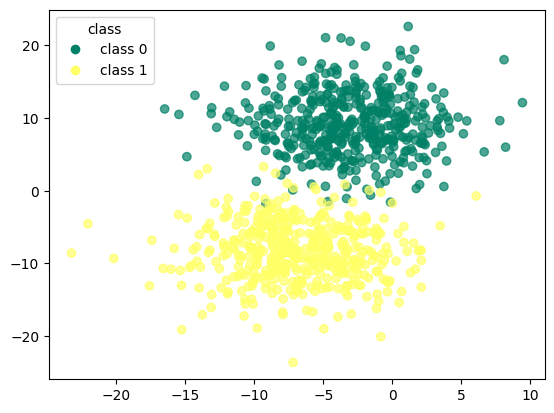

In [1121]:
scatter = plt.scatter(df_umap_trim_kmeans.iloc[:, 0], df_umap_trim_kmeans.iloc[:, 1], 
                      c=df_umap_trim_kmeans['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_umap_trim_kmeans['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

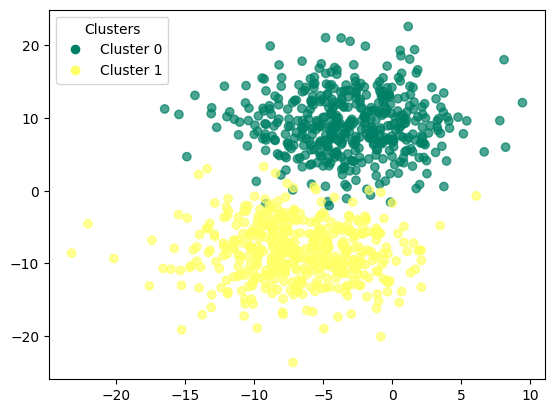

In [1122]:
scatter = plt.scatter(df_umap_trim_kmeans.iloc[:, 0], df_umap_trim_kmeans.iloc[:, 1], 
                      c=df_umap_trim_kmeans['trim_kmeans_umap'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_umap_trim_kmeans['trim_kmeans_umap'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

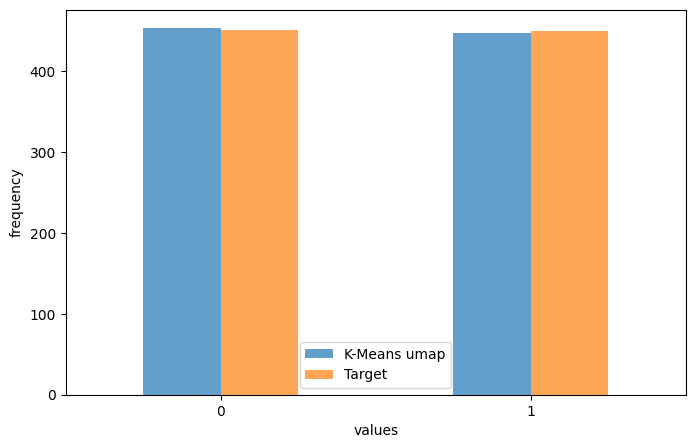

In [1123]:
counts_kmeans = df_umap_trim_kmeans['trim_kmeans_umap'].value_counts().sort_index()
counts_target = df_umap_trim_kmeans['target'].value_counts().sort_index()

df_counts = pd.DataFrame({'K-Means umap': counts_kmeans, 'Target': counts_target}).fillna(0)

df_counts.plot(kind='bar', figsize=(8, 5), alpha=0.7)
plt.xlabel("values")
plt.ylabel("frequency")
plt.legend(["K-Means umap", "Target"])
plt.xticks(rotation=0)  
plt.show()

In [1124]:
print(confusion_matrix(df_umap_trim_kmeans['target'],df_umap_trim_kmeans['trim_kmeans_umap']))

[[451   0]
 [  2 447]]


In [1125]:
print(classification_report(df_umap_trim_kmeans['target'],df_umap_trim_kmeans['trim_kmeans_umap'])) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       451
           1       1.00      1.00      1.00       449

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



## dbscan

In [1126]:
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.show()

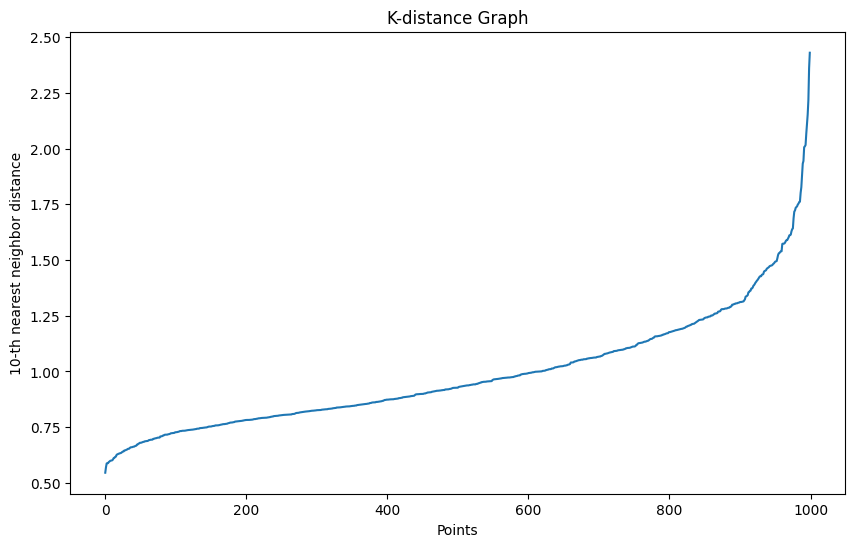

In [1127]:
plot_k_distance_graph(X_values,k=10) 

In [1128]:
dbscan = DBSCAN(eps=1.3,min_samples=10) # min_samples = 2*n_features

In [1129]:
dbscan.fit(X_values)

DBSCAN(eps=1.3, min_samples=10)

In [1130]:
df_dbscan = corr_dataset.copy()

In [1131]:
df_dbscan['dbscan'] = dbscan.labels_

In [1132]:
df_dbscan

vab_1      vab_2      vab_3     vab_4      vab_5  target  dbscan
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0       0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0       0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0       0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0       0
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0       0
..        ...        ...        ...       ...        ...     ...     ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1       0
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1       0
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1       0
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1       0
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1       0

[1000 rows x 7 columns]

In [1133]:
print(df_dbscan['dbscan'].value_counts())

dbscan
 0    980
-1     20
Name: count, dtype: int64


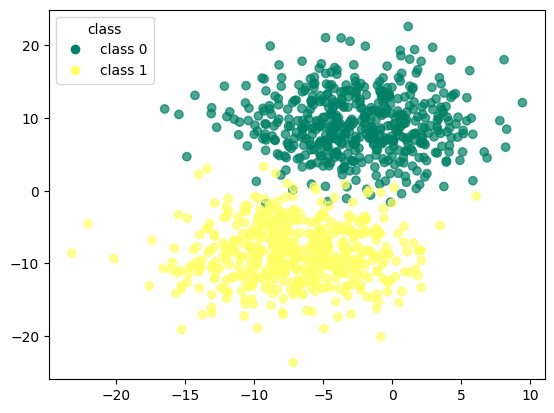

In [1134]:
scatter = plt.scatter(df_dbscan.iloc[:, 0], df_dbscan.iloc[:, 1], 
                      c=df_dbscan['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_dbscan['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

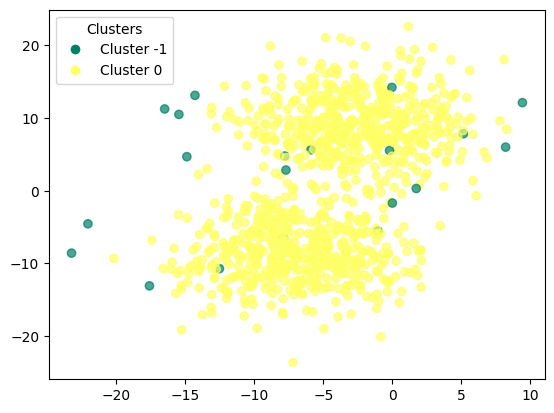

In [1135]:
scatter = plt.scatter(df_dbscan.iloc[:, 0], df_dbscan.iloc[:, 1], 
                      c=df_dbscan['dbscan'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_dbscan['dbscan'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [1136]:
print(confusion_matrix(df_dbscan['target'],df_dbscan['dbscan']))

[[  0   0   0]
 [ 13 487   0]
 [  7 493   0]]


In [1137]:
print(classification_report(df_dbscan['target'],df_dbscan['dbscan']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.50      0.97      0.66       500
           1       0.00      0.00      0.00       500

    accuracy                           0.49      1000
   macro avg       0.17      0.32      0.22      1000
weighted avg       0.25      0.49      0.33      1000



### dbscan with pca

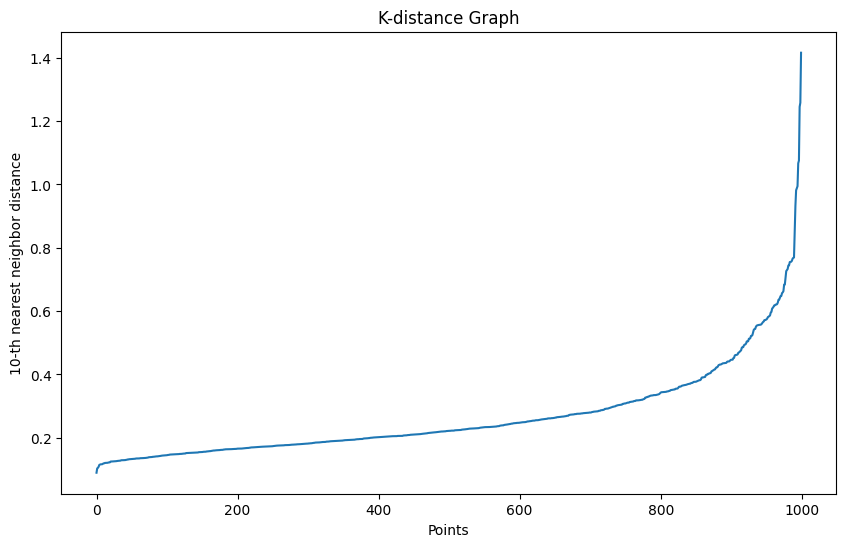

In [1138]:
plot_k_distance_graph(scores_pca,k=10)

In [1139]:
dbscan_pca = DBSCAN(eps=0.6,min_samples=10)

In [1140]:
dbscan_pca.fit(scores_pca)

DBSCAN(eps=0.6, min_samples=10)

In [1141]:
df_pca_dbscan = corr_dataset.copy()

In [1142]:
df_pca_dbscan["dbscan_pca"] = dbscan_pca.labels_

In [1143]:
df_pca_dbscan

vab_1      vab_2      vab_3     vab_4      vab_5  target  dbscan_pca
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0           0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0           0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0           0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0           0
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0           0
..        ...        ...        ...       ...        ...     ...         ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1           0
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1           0
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1           0
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1           0
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1           0

[1000 rows x 7 columns]

In [1144]:
print(df_pca_dbscan['dbscan_pca'].value_counts())

dbscan_pca
 0    991
-1      9
Name: count, dtype: int64


In [1145]:
print(confusion_matrix(df_pca_dbscan['target'],df_pca_dbscan['dbscan_pca']))

[[  0   0   0]
 [  7 493   0]
 [  2 498   0]]


In [1146]:
print(classification_report(df_pca_dbscan['target'],df_pca_dbscan['dbscan_pca']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.50      0.99      0.66       500
           1       0.00      0.00      0.00       500

    accuracy                           0.49      1000
   macro avg       0.17      0.33      0.22      1000
weighted avg       0.25      0.49      0.33      1000



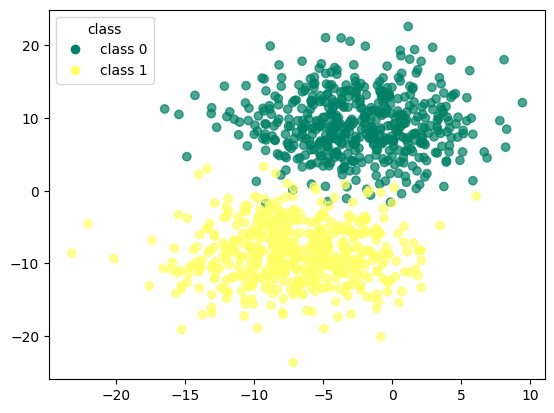

In [1147]:
scatter = plt.scatter(df_pca_dbscan.iloc[:, 0], df_pca_dbscan.iloc[:, 1], 
                      c=df_pca_dbscan['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_dbscan['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

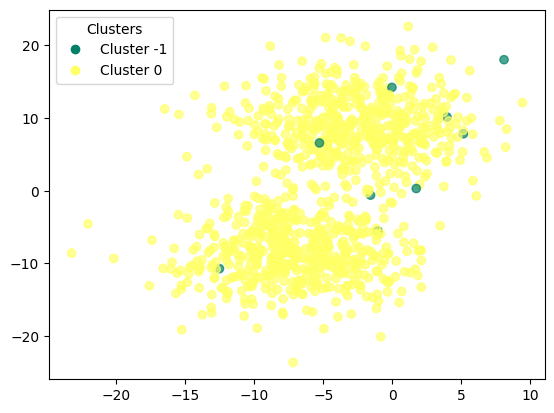

In [1148]:
scatter = plt.scatter(df_pca_dbscan.iloc[:, 0], df_pca_dbscan.iloc[:, 1], 
                      c=df_pca_dbscan['dbscan_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_dbscan['dbscan_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### dbscan with t-SNE

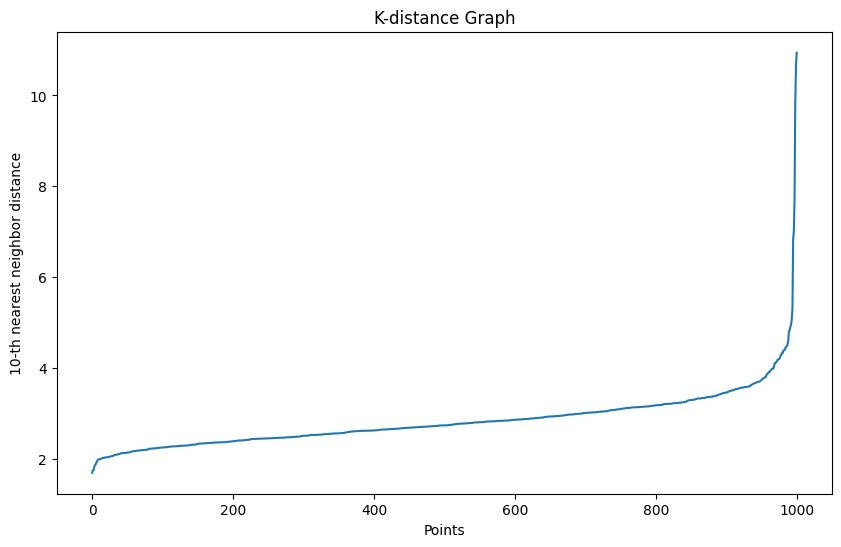

In [1149]:
plot_k_distance_graph(X_tsne,k=10)

In [1150]:
dbscan_tsne = DBSCAN(eps=4,min_samples=10)

In [1151]:
dbscan_tsne.fit(X_tsne)

DBSCAN(eps=4, min_samples=10)

In [1152]:
df_tsne_dbscan = corr_dataset.copy()

In [1153]:
df_tsne_dbscan['dbscan_tsne'] = dbscan_tsne.labels_

In [1154]:
df_tsne_dbscan

vab_1      vab_2      vab_3     vab_4      vab_5  target  dbscan_tsne
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0            0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0            0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0            0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0            0
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0            0
..        ...        ...        ...       ...        ...     ...          ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1            1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1            1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1            1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1            1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1            1

[1000 rows x 7 columns]

In [1155]:
print(df_tsne_dbscan['dbscan_tsne'].value_counts())

dbscan_tsne
 0    501
 1    492
-1      7
Name: count, dtype: int64


In [1156]:
print(confusion_matrix(df_tsne_dbscan['target'],df_tsne_dbscan['dbscan_tsne']))

[[  0   0   0]
 [  2 498   0]
 [  5   3 492]]


In [1157]:
print(classification_report(df_tsne_dbscan['target'],df_tsne_dbscan['dbscan_tsne']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.99      1.00      1.00       500
           1       1.00      0.98      0.99       500

    accuracy                           0.99      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       1.00      0.99      0.99      1000



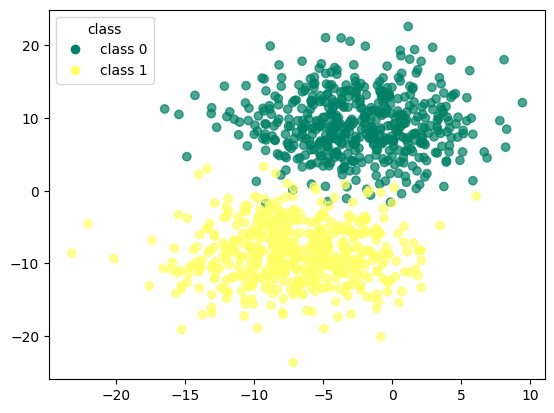

In [1158]:
scatter = plt.scatter(df_tsne_dbscan.iloc[:, 0], df_tsne_dbscan.iloc[:, 1], 
                      c=df_tsne_dbscan['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_dbscan['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

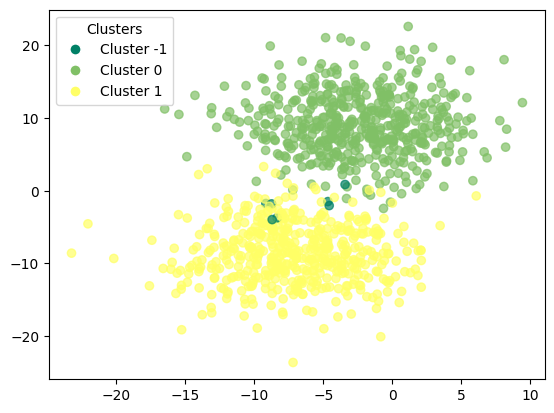

In [1159]:
scatter = plt.scatter(df_tsne_dbscan.iloc[:, 0], df_tsne_dbscan.iloc[:, 1], 
                      c=df_tsne_dbscan['dbscan_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_dbscan['dbscan_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

### dbscan with umap

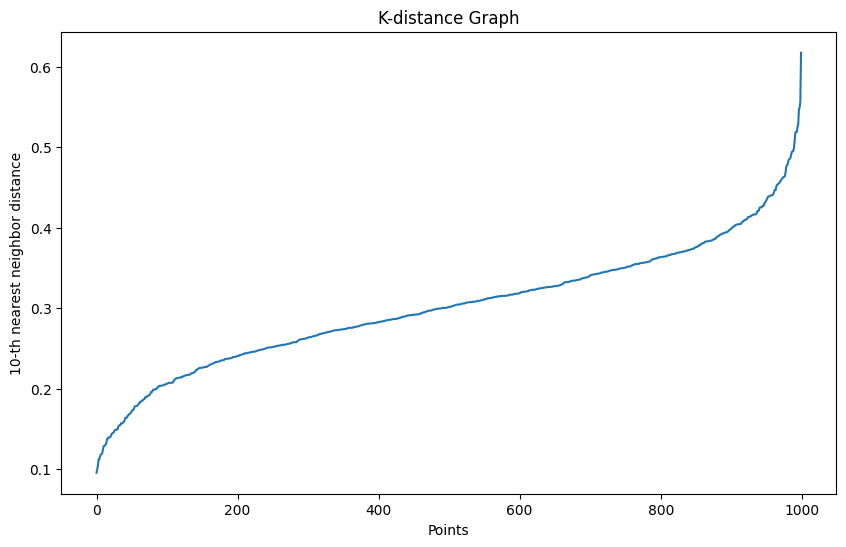

In [1160]:
plot_k_distance_graph(X_umap,k=10)

In [1161]:
dbscan_umap = DBSCAN(eps=0.5,min_samples=10)

In [1162]:
dbscan_umap.fit(X_umap)

DBSCAN(min_samples=10)

In [1163]:
df_umap_dbscan = corr_dataset.copy()

In [1164]:
df_umap_dbscan['dbscan_umap'] = dbscan_umap.labels_

In [1165]:
df_umap_dbscan

vab_1      vab_2      vab_3     vab_4      vab_5  target  dbscan_umap
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0            0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0            0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0            0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0            0
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0            0
..        ...        ...        ...       ...        ...     ...          ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1            1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1            1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1            1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1            1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1            1

[1000 rows x 7 columns]

In [1166]:
print(df_umap_dbscan['dbscan_umap'].value_counts())

dbscan_umap
0    505
1    495
Name: count, dtype: int64


In [1167]:
print(confusion_matrix(df_umap_dbscan['target'],df_umap_dbscan['dbscan_umap']))

[[500   0]
 [  5 495]]


In [1168]:
print(classification_report(df_umap_dbscan['target'],df_umap_dbscan['dbscan_umap']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



## GMM - Gaussian Mixture Models

In [1169]:
gmm = GaussianMixture(n_components=2,init_params='k-means++',random_state=42)

In [1170]:
gmm.fit(X_values)

GaussianMixture(init_params='k-means++', n_components=2, random_state=42)

In [1171]:
df_gmm = corr_dataset.copy()

In [1172]:
df_gmm['gmm'] = gmm.predict(X_values)

In [1173]:
df_gmm

vab_1      vab_2      vab_3     vab_4      vab_5  target  gmm
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0    0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0    0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0    0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0    0
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0    0
..        ...        ...        ...       ...        ...     ...  ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1    1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1    1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1    1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1    1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1    1

[1000 rows x 7 columns]

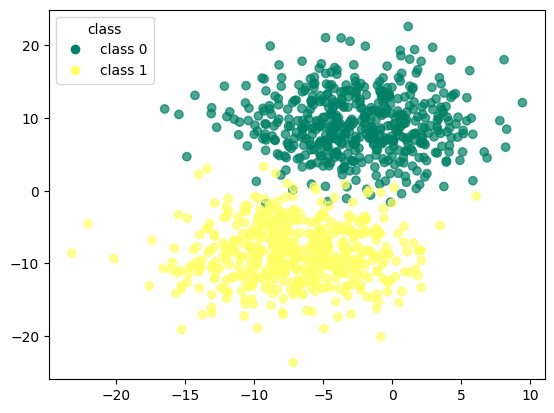

In [1174]:
scatter = plt.scatter(df_gmm.iloc[:, 0], df_gmm.iloc[:, 1], 
                      c=df_gmm['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_gmm['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

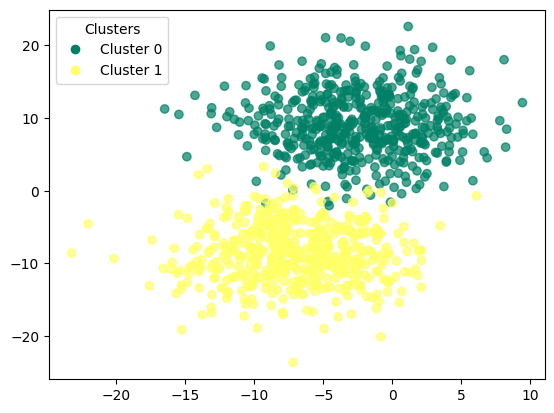

In [1175]:
scatter = plt.scatter(df_gmm.iloc[:, 0], df_gmm.iloc[:, 1], 
                      c=df_gmm['gmm'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_gmm['gmm'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [1176]:
print(confusion_matrix(df_gmm['target'],df_gmm['gmm']))

[[500   0]
 [  3 497]]


In [1177]:
print(classification_report(df_gmm['target'],df_gmm['gmm']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       500
           1       1.00      0.99      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



### GMM with pca

In [1178]:
gmm_pca = GaussianMixture(n_components=2,init_params='k-means++',random_state=42)

In [1179]:
gmm_pca.fit(scores_pca)

GaussianMixture(init_params='k-means++', n_components=2, random_state=42)

In [1180]:
df_pca_gmm = corr_dataset.copy()

In [1181]:
df_pca_gmm['gmm_pca'] = gmm_pca.predict(scores_pca)

In [1182]:
df_pca_gmm

vab_1      vab_2      vab_3     vab_4      vab_5  target  gmm_pca
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0        0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0        0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0        0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0        1
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0        0
..        ...        ...        ...       ...        ...     ...      ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1        1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1        1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1        1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1        1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1        1

[1000 rows x 7 columns]

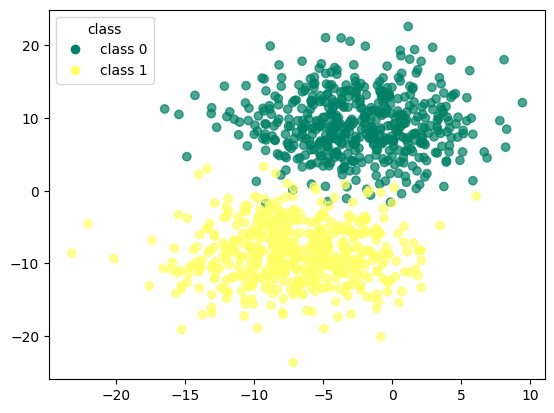

In [1183]:
scatter = plt.scatter(df_pca_gmm.iloc[:, 0], df_pca_gmm.iloc[:, 1], 
                      c=df_pca_gmm['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_pca_gmm['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

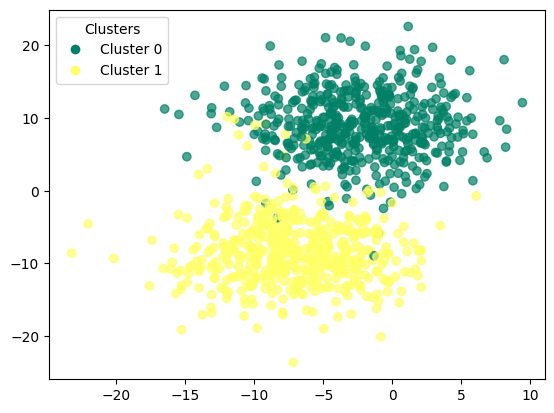

In [1184]:
scatter = plt.scatter(df_pca_gmm.iloc[:, 0], df_pca_gmm.iloc[:, 1], 
                      c=df_pca_gmm['gmm_pca'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_pca_gmm['gmm_pca'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [1185]:
print(confusion_matrix(df_pca_gmm['target'],df_pca_gmm['gmm_pca']))

[[490  10]
 [  7 493]]


In [1186]:
print(classification_report(df_pca_gmm['target'],df_pca_gmm['gmm_pca']))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       500
           1       0.98      0.99      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



### GMM with t-SNE

In [1187]:
gmm_tsne = GaussianMixture(n_components=2,init_params='k-means++',random_state=42)

In [1188]:
gmm_tsne.fit(X_tsne)

GaussianMixture(init_params='k-means++', n_components=2, random_state=42)

In [1189]:
df_tsne_gmm = corr_dataset.copy()

In [1190]:
df_tsne_gmm['gmm_tsne'] = gmm_tsne.predict(X_tsne)

In [1191]:
df_tsne_gmm

vab_1      vab_2      vab_3     vab_4      vab_5  target  gmm_tsne
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0         0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0         0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0         0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0         0
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0         0
..        ...        ...        ...       ...        ...     ...       ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1         1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1         1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1         1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1         1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1         1

[1000 rows x 7 columns]

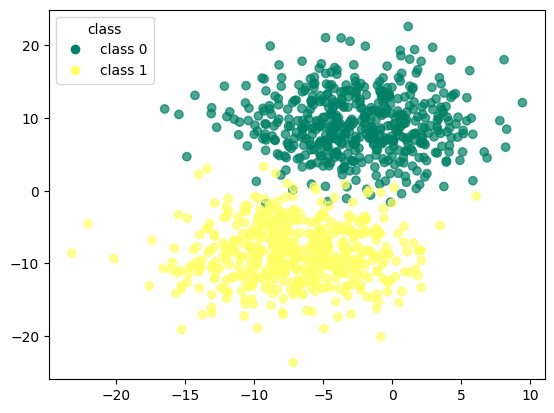

In [1192]:
scatter = plt.scatter(df_tsne_gmm.iloc[:, 0], df_tsne_gmm.iloc[:, 1], 
                      c=df_tsne_gmm['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_tsne_gmm['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

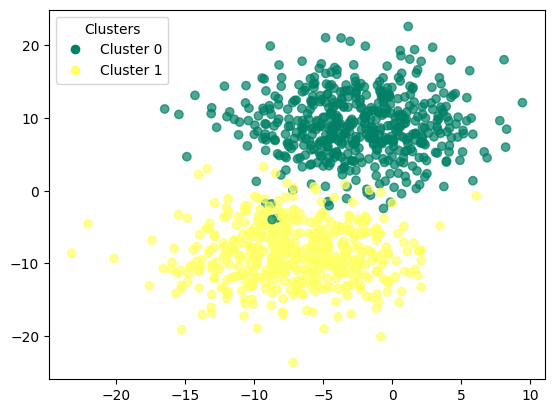

In [1193]:
scatter = plt.scatter(df_tsne_gmm.iloc[:, 0], df_tsne_gmm.iloc[:, 1], 
                      c=df_tsne_gmm['gmm_tsne'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_tsne_gmm['gmm_tsne'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [1194]:
print(confusion_matrix(df_tsne_gmm['target'],df_tsne_gmm['gmm_tsne']))

[[500   0]
 [  7 493]]


In [1195]:
print(classification_report(df_tsne_gmm['target'],df_tsne_gmm['gmm_tsne']))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



### GMM with umap

In [1196]:
gmm_umap = GaussianMixture(n_components=2,init_params='k-means++',random_state=42)

In [1197]:
gmm_umap.fit(X_umap)

GaussianMixture(init_params='k-means++', n_components=2, random_state=42)

In [1198]:
df_umap_gmm = corr_dataset.copy()

In [1199]:
df_umap_gmm['gmm_umap'] = gmm_umap.predict(X_umap)

In [1200]:
df_umap_gmm

vab_1      vab_2      vab_3     vab_4      vab_5  target  gmm_umap
0   -4.650073   7.076623  -3.291586 -0.346540  -3.255392       0         0
1   -6.335035  13.785559   6.136146 -0.910381  -7.882775       0         0
2    3.903740  11.599888   4.664921  3.146283  -6.521366       0         0
3   -4.844349   0.611977  12.974970  4.228953  -4.623374       0         0
4   -3.946004   4.871646   2.781589 -4.454364   0.661903       0         0
..        ...        ...        ...       ...        ...     ...       ...
995 -7.100271  -2.580640   3.944107 -0.700247  -1.107526       1         1
996 -7.183624  -9.742562  10.008001  3.583407  -0.170281       1         1
997 -9.782534 -10.148409  -0.577255 -4.048875  -0.842339       1         1
998  0.842822  -7.101524  11.274309 -2.698003  10.849289       1         1
999 -1.146299 -16.198506   2.202632  4.150342   7.785018       1         1

[1000 rows x 7 columns]

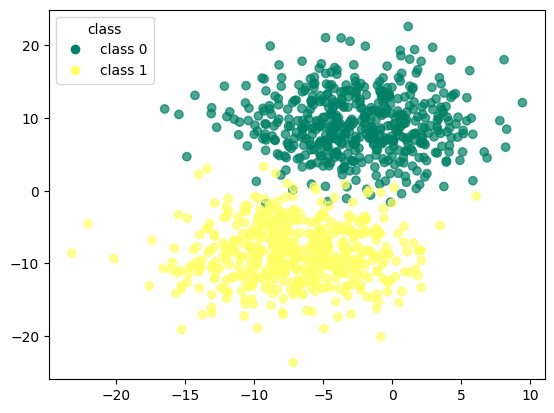

In [1213]:
scatter = plt.scatter(df_umap_gmm.iloc[:, 0], df_umap_gmm.iloc[:, 1], 
                      c=df_umap_gmm['target'], cmap='summer', alpha=0.7)

unique_labels = np.unique(df_umap_gmm['target'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'class {label}',
                          markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) 
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="class")
plt.show()

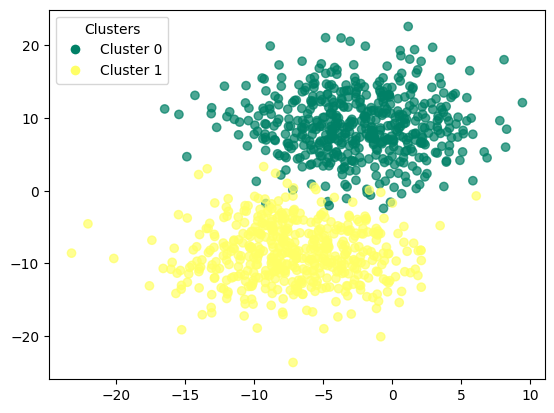

In [1214]:
scatter = plt.scatter(df_umap_gmm.iloc[:, 0], df_umap_gmm.iloc[:, 1], 
                      c=df_umap_gmm['gmm_umap'], cmap='summer', alpha=0.7)
unique_clusters = np.unique(df_umap_gmm['gmm_umap'])
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                          markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=8) 
                   for cluster in unique_clusters]
plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [1215]:
print(confusion_matrix(df_umap_gmm['target'],df_umap_gmm['gmm_umap']))

[[500   0]
 [  5 495]]


In [1216]:
print(classification_report(df_umap_gmm['target'],df_umap_gmm['gmm_umap']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



# overall results k-means

In [1201]:
print(classification_report(df_kmeans['target'],df_kmeans['k_means']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       0.99      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [1202]:
print(classification_report(df_pca_kmeans['target'],df_pca_kmeans['kmeans_pca']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       500
           1       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [1203]:
print(classification_report(df_tsne_kmeans['target'],df_tsne_kmeans['kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [1204]:
print(classification_report(df_umap_kmeans['target'],df_umap_kmeans['kmeans_umap'])) 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



# overall results trimmed k-means

In [1205]:
print(classification_report(df_trim_kmeans['target'],df_trim_kmeans['trim_kmeans']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       442
           1       1.00      0.98      0.99       458

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



In [1206]:
print(classification_report(df_pca_trim_kmeans['target'],df_pca_trim_kmeans['trim_kmeans_pca']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       442
           1       0.98      0.97      0.98       458

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



In [1207]:
print(classification_report(df_tsne_trim_kmeans['target'],df_tsne_trim_kmeans['trim_kmeans_tsne'])) 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       442
           1       1.00      0.96      0.98       458

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



In [1208]:
print(classification_report(df_umap_trim_kmeans['target'],df_umap_trim_kmeans['trim_kmeans_umap'])) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       451
           1       1.00      1.00      1.00       449

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



# overall results dbscan

In [1209]:
print(classification_report(df_dbscan['target'],df_dbscan['dbscan']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.50      0.97      0.66       500
           1       0.00      0.00      0.00       500

    accuracy                           0.49      1000
   macro avg       0.17      0.32      0.22      1000
weighted avg       0.25      0.49      0.33      1000



In [1210]:
print(classification_report(df_pca_dbscan['target'],df_pca_dbscan['dbscan_pca']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.50      0.99      0.66       500
           1       0.00      0.00      0.00       500

    accuracy                           0.49      1000
   macro avg       0.17      0.33      0.22      1000
weighted avg       0.25      0.49      0.33      1000



In [1211]:
print(classification_report(df_tsne_dbscan['target'],df_tsne_dbscan['dbscan_tsne']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.99      1.00      1.00       500
           1       1.00      0.98      0.99       500

    accuracy                           0.99      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       1.00      0.99      0.99      1000



In [1212]:
print(classification_report(df_umap_dbscan['target'],df_umap_dbscan['dbscan_umap']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000

